This code is directily simulating the Hamiltonian of raw MS gate with only one mode, followed by two single qubit rotaion $R_{\theta}(\pi/2)$ on both ions. Measuring the $\sigma_{z1}\sigma_{z2}$ as the parity.

In [1]:
import qutip as qt
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import datetime
from numpy import linalg
#from numpy import *
import pandas as pd
from tqdm import tqdm
%matplotlib inline

class MSGateExp:
    def __init__(self, 
                 Nmax = 10, 
                 eta = 0.1,
                 omega_r = np.array([1,1]) * np.pi * 2,
                 omega_b = np.array([1,1]) * np.pi * 2,
                 delta_r = np.array([2,2]) * np.pi * 2,
                 delta_b = np.array([-2,-2]) * np.pi * 2,
                 phi_r = 0,
                 phi_b = 0,
                 Gamma = 0, # Heating rate
                 tau = 10, # Motional coherence time
                 nth = 0.1,
                 s_init = tensor(ket2dm(tensor(fock(2, 1), fock(2, 1))), thermal_dm(10, 0.5)),
                 output = None
                ):
        self.Nmax = Nmax
        self.eta = eta
        self.omega_r = omega_r
        self.omega_b = omega_b
        self.delta_r = delta_r
        self.delta_b = delta_b
        self.phi_r = phi_r
        self.phi_b = phi_b
        self.Gamma = Gamma # Heating rate
        self.tau = tau
        self.nth = nth
        self.s_init = s_init
        self.output = output
    
    def solve(self, t1):
            
        H0 = -1j*self.eta/2 * \
            self.omega_r[0]*np.exp(1j*self.phi_r) * \
            tensor(sigmap(), qeye(2), destroy(self.Nmax))
        def H0_coeff(t, args):
            return np.exp(-1j*self.delta_r[0]*t)
        
        H1 = 1j*self.eta/2 * \
            self.omega_r[0]*np.exp(-1j*self.phi_r) * \
            tensor(sigmam(), qeye(2), create(self.Nmax))
        def H1_coeff(t, args):
            return np.exp(1j*self.delta_r[0]*t)
        
        H2 = -1j*self.eta/2 * \
            self.omega_b[0]*np.exp(1j*self.phi_b) * \
            tensor(sigmap(), qeye(2), create(self.Nmax))
        def H2_coeff(t, args):
            return np.exp(-1j*self.delta_b[0]*t)

        H3 = 1j*self.eta/2 * \
            self.omega_b[0]*np.exp(-1j*self.phi_b) * \
            tensor(sigmam(), qeye(2), destroy(self.Nmax))
        def H3_coeff(t, args):
            return np.exp(1j*self.delta_b[0]*t)

        H4 = -1j*self.eta/2 * \
            self.omega_r[1]*np.exp(1j*self.phi_r) * \
            tensor(qeye(2), sigmap(), destroy(self.Nmax))
        def H4_coeff(t, args):
            return np.exp(-1j*self.delta_r[1]*t)

        H5 = 1j*self.eta/2 * \
            self.omega_r[1]*np.exp(-1j*self.phi_r) * \
            tensor(qeye(2), sigmam(), create(self.Nmax))
        def H5_coeff(t, args):
            return np.exp(1j*self.delta_r[1]*t)

        H6 = -1j*self.eta/2 * \
            self.omega_b[1]*np.exp(1j*self.phi_b) * \
            tensor(qeye(2), sigmap(), create(self.Nmax))
        def H6_coeff(t, args):
            return np.exp(-1j*self.delta_b[1]*t)

        H7 = 1j*self.eta/2 * \
            self.omega_b[1]*np.exp(-1j*self.phi_b) * \
            tensor(qeye(2), sigmam(), destroy(self.Nmax))
        def H7_coeff(t, args):
            return np.exp(1j*self.delta_b[1]*t)
        
        H = [[H0, H0_coeff], [H1, H1_coeff], [H2, H2_coeff], [H3, H3_coeff],
             [H4, H4_coeff], [H5, H5_coeff], [H6, H6_coeff], [H7, H7_coeff]]
        
        Heye = tensor(qeye(2), qeye(2), qeye(self.Nmax))
        
        c_ops = [tensor(tensor(qeye(2), qeye(2)), np.sqrt(self.Gamma)*destroy(self.Nmax)),
                 tensor(tensor(qeye(2), qeye(2)), np.sqrt(self.Gamma)*create(self.Nmax))]
        
        if self.tau != 0:
            c_ops.append(tensor(qeye(2), qeye(2), np.sqrt(2/self.tau)*create(self.Nmax)*destroy(self.Nmax)))
        
        self.output = mesolve(H, self.s_init, t1, c_ops, [])
        
    def time_scan(self,
                 t_start,
                 t_stop,
                 Nsample,
                  isPlot = True
                 ):
        now = datetime.datetime.now()
        t_list = np.linspace(t_start, t_stop, Nsample)
        self.solve(t_list)
        self.measure(self.output.states, t_list, isPlot)
        now2 = datetime.datetime.now()
        #print(now2-now)
        return self.output.states
        
    
    def StarkShift_scan(self,
                 t_start,
                 t_stop,
                 Nsample,
                 StarkShiftScanList,
                       ):
        
        now = datetime.datetime.now()
        t_list = np.linspace(t_start, t_stop, Nsample)
        ScanResult_ee = []
        ScanResult_gg = []
        
        s_ee = tensor(fock(2, 0), fock(2, 0))
        s_gg = tensor(fock(2, 1), fock(2, 1))
        def _measure(state, s_meas):
            state_ptr = state.ptrace([0,1])  
            result = s_meas.dag()*state_ptr*s_meas
            if result.data.data.size:
                return np.real(result.data.data[0])
            else:
                return 0.0    # np.array has same type
            
        for ss in StarkShiftScanList:
            self.delta_r = delta_r + ss
            self.delta_b = delta_b + ss
            
            self.solve(t_list)
            self.measure(self.output.states, t_list)
            ee = _measure(self.output.states[-1], s_ee)
            gg = _measure(self.output.states[-1], s_gg)
            ScanResult_ee.append(ee)
            ScanResult_gg.append(gg)
        now2 = datetime.datetime.now()
        print(now2-now)
        
        plt.plot(StarkShiftScanList, ScanResult_ee, label = '11')
        plt.plot(StarkShiftScanList, ScanResult_gg, label = '00')
        plt.xlabel('Stark Shift scan')
        plt.ylabel('Probability')
        plt.legend()
        
    def detuning_scan(self,
                      delta_start,
                      delta_stop,
                      Nsample,
                      t1=np.linspace(0, 0.5, 2),
                      t2=np.linspace(0, 0.5, 2),
                     ):
        delta_list = np.linspace(delta_start, delta_stop, Nsample)
        states = []
        for delta in delta_list:
            self.delta_r = delta*np.array([1, 1])*np.pi*2
            self.delta_b = delta*np.array([-1, -1])*np.pi*2
            self.s_init = tensor(ket2dm(tensor(fock(2, 1), fock(2, 1))), thermal_dm(self.Nmax, 0.5))
            self.solve(t1)
            states.append(self.output.states[-1])
        #states = np.array(states)
        self.measure(states, delta_list)
        
    def parity_scan(self,
                    t_gate,
                    phi_list = np.linspace(0,2*np.pi, 51),
                    omega1 = 0,
                    omega2 = 0,
                    t_rotation = 0,
                    deltaPhi = 0
                 ):
        output_states = self.time_scan(0, t_gate, 2)
        
        
        tlist = np.linspace(0, t_rotation, 101)
        c_ops = [tensor(tensor(qeye(2), qeye(2)), np.sqrt(self.Gamma)*destroy(self.Nmax)),
                 tensor(tensor(qeye(2), qeye(2)), np.sqrt(self.Gamma)*create(self.Nmax))]
        s_init = output_states[-1]
        parity = [] 
        for phi in phi_list:
            sigma_phi = np.cos(phi)*sigmax() - np.sin(phi)*sigmay()
            sigma_phi_2 = np.cos(phi+deltaPhi)*sigmax() - np.sin(phi+deltaPhi)*sigmay()
            H1 = omega1*tensor(sigma_phi, qeye(2), qeye(self.Nmax))
            H2 = omega2*tensor(qeye(2), sigma_phi_2, qeye(self.Nmax))
            H = H1+H2
            self.output = mesolve(H, s_init, tlist, c_ops, [])
            szz = (self.output.states[-1].ptrace([0,1])*tensor(sigmaz(),sigmaz())).tr() 
            parity.append(szz)
        plt.plot(phi_list, parity)
        plt.xlabel('Phase')
        plt.ylabel('Parity')
        plt.ylim([-1.001,1.001])
        return s_init
        
    def parity_scan_repeatable(self,
                    t_gate,
                    phi,
                    omega1 = 0,
                    omega2 = 0,
                    t_rotation = 0,
                    deltaPhi = 0
                 ):
        output_states = self.time_scan(0, t_gate, 2, isPlot = False)
        
        
        tlist = np.linspace(0, t_rotation, 101)
        c_ops = [tensor(tensor(qeye(2), qeye(2)), np.sqrt(self.Gamma)*destroy(self.Nmax)),
                 tensor(tensor(qeye(2), qeye(2)), np.sqrt(self.Gamma)*create(self.Nmax))]
        s_init = output_states[-1]
        
        sigma_phi = np.cos(phi)*sigmax() - np.sin(phi)*sigmay()
        sigma_phi_2 = np.cos(phi+deltaPhi)*sigmax() - np.sin(phi+deltaPhi)*sigmay()
        H1 = omega1*tensor(sigma_phi, qeye(2), qeye(self.Nmax))
        H2 = omega2*tensor(qeye(2), sigma_phi_2, qeye(self.Nmax))
        H = H1+H2
        self.output = mesolve(H, s_init, tlist, c_ops, [])
        szz = (self.output.states[-1].ptrace([0,1])*tensor(sigmaz(),sigmaz())).tr() 
        return szz
        
        
    def measure(self, states, x_axis, isPlot = True):
        # states: np.array of dm includes two ions and phonons
        s_ee = tensor(fock(2, 0), fock(2, 0))
        s_gg = tensor(fock(2, 1), fock(2, 1))
        s_eg = (tensor(fock(2, 0), fock(2, 1)) +
                tensor(fock(2, 1), fock(2, 0))).unit()
        
        def _measure(state, s_meas):
            state_ptr = state.ptrace([0,1])  
            result = s_meas.dag()*state_ptr*s_meas
            if result.data.data.size:
                return np.real(result.data.data[0])
            else:
                return 0.0    # np.array has same type
         
        ee = np.zeros(len(states))
        gg = np.zeros(len(states))
        eg = np.zeros(len(states))
        for i in range(len(states)):
            ee[i] = _measure(states[i], s_ee)
            gg[i] = _measure(states[i], s_gg)
            eg[i] = _measure(states[i], s_eg)
        if isPlot:
            fig, ax = plt.subplots()
            ax.plot(x_axis, ee)
            ax.plot(x_axis, gg)
            ax.plot(x_axis, eg)
            # ax.set_xlabel()
            ax.set_ylabel('Probability')
            ax.legend(('11', '00', '01+10'))
            plt.show()
       

t_gate = 250.0us


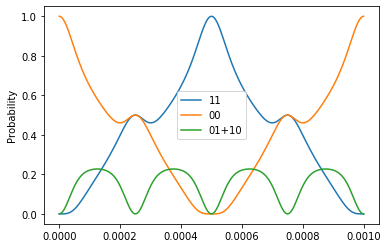

In [2]:
omega = 2e4
eta = 0.1
delta = 2*eta*omega
tg = 1/delta # pi/2 gate time
print('t_gate = '+str(tg*1e6)+'us')
nth = 0.1
Nmax = 10
exp1 = MSGateExp(Nmax=Nmax,eta = eta,
                 omega_r = np.array([omega,omega]) * np.pi * 2,
                 omega_b = np.array([omega,omega]) * np.pi * 2,
                 delta_r = np.array([delta,delta]) * np.pi * 2,
                 delta_b = np.array([-delta,-delta]) * np.pi * 2,
                 phi_r = 0,
                 phi_b = 0,
                 Gamma = 0, # Heating rate
                 tau = 10,
                 nth = nth,
                 s_init = tensor(ket2dm(tensor(fock(2, 1), fock(2, 1))), thermal_dm(Nmax, nth)),
                 output = None)
states = exp1.time_scan(0, 4*tg, 200)

## Idea case:

t_gate = 250.0us


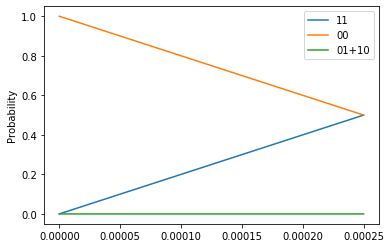

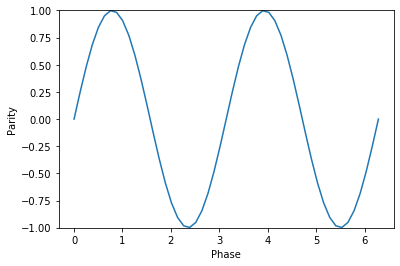

In [3]:
omega = 2e4
eta = 0.1
delta = 2*eta*omega
tg = 1/delta # pi/2 gate time
print('t_gate = '+str(tg*1e6)+'us')
nth = 0.1
Nmax = 10
exp2 = MSGateExp(Nmax=Nmax,eta = eta,
                 omega_r = np.array([omega,omega]) * np.pi * 2,
                 omega_b = np.array([omega,omega]) * np.pi * 2,
                 delta_r = np.array([delta,delta]) * np.pi * 2,
                 delta_b = np.array([-delta,-delta]) * np.pi * 2,
                 phi_r = 0,
                 phi_b = 0,
                 Gamma = 0, # Heating rate
                 nth = nth,
                 s_init = tensor(ket2dm(tensor(fock(2, 1), fock(2, 1))), thermal_dm(Nmax, nth)),
                 output = None)
t_Raman = 6e-6 # pi time
omega = np.pi/2/t_Raman
omega1 = omega
omega2 = omega
szz = exp2.parity_scan(t_gate = tg,
                    phi_list = np.linspace(0,2*np.pi, 51),
                    omega1 = omega1,
                    omega2 = omega2,
                    t_rotation = t_Raman/2 # pi/2 rotation
                         )

Three gates

t_gate = 250.0us


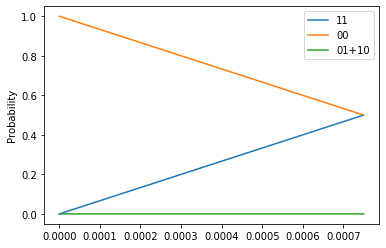

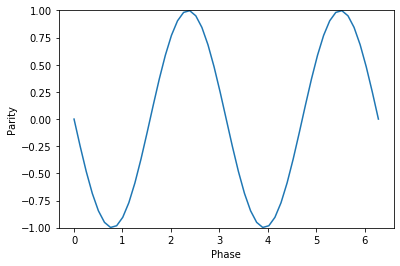

In [224]:
omega = 2e4
eta = 0.1
delta = 2*eta*omega
tg = 1/delta # pi/2 gate time
print('t_gate = '+str(tg*1e6)+'us')
nth = 0.1
Nmax = 10
exp2 = MSGateExp(Nmax=Nmax,eta = eta,
                 omega_r = np.array([omega,omega]) * np.pi * 2,
                 omega_b = np.array([omega,omega]) * np.pi * 2,
                 delta_r = np.array([delta,delta]) * np.pi * 2,
                 delta_b = np.array([-delta,-delta]) * np.pi * 2,
                 phi_r = 0,
                 phi_b = 0,
                 Gamma = 0, # Heating rate
                 nth = nth,
                 s_init = tensor(ket2dm(tensor(fock(2, 1), fock(2, 1))), thermal_dm(Nmax, nth)),
                 output = None)
t_Raman = 6e-6 # pi time
omega = np.pi/2/t_Raman
omega1 = omega
omega2 = omega
szz = exp2.parity_scan(t_gate = tg*3,
                    phi_list = np.linspace(0,2*np.pi, 51),
                    omega1 = omega1,
                    omega2 = omega2,
                    t_rotation = t_Raman/2 # pi/2 rotation
                         )

## Reasons of offset:
    1. Carrier rotation mis-calibration

t_gate = 250.0us


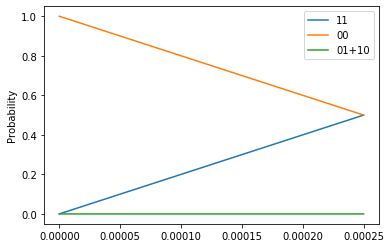

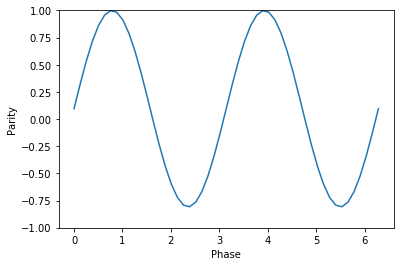

In [225]:
omega = 2e4
eta = 0.1
delta = 2*eta*omega
tg = 1/delta # pi/2 gate time
print('t_gate = '+str(tg*1e6)+'us')
nth = 0.1
Nmax = 10
exp2 = MSGateExp(Nmax=Nmax,eta = eta,
                 omega_r = np.array([omega,omega]) * np.pi * 2,
                 omega_b = np.array([omega,omega]) * np.pi * 2,
                 delta_r = np.array([delta,delta]) * np.pi * 2,
                 delta_b = np.array([-delta,-delta]) * np.pi * 2,
                 phi_r = 0,
                 phi_b = 0,
                 Gamma = 0, # Heating rate
                 nth = nth,
                 s_init = tensor(ket2dm(tensor(fock(2, 1), fock(2, 1))), thermal_dm(Nmax, nth)),
                 output = None)
t_Raman = 6e-6 # pi time
omega = np.pi/2/t_Raman
omega1 = omega
omega2 = omega
szz = exp2.parity_scan(t_gate = tg,
                    phi_list = np.linspace(0,2*np.pi, 51),
                    omega1 = omega1,
                    omega2 = omega2,
                    t_rotation = t_Raman/2*1.2 # pi/2 rotation
                         )

## Reasons of offset:
    2. MS gate mis-calibration

t_gate = 250.0us


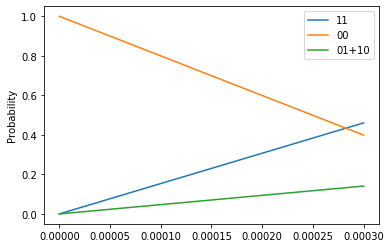

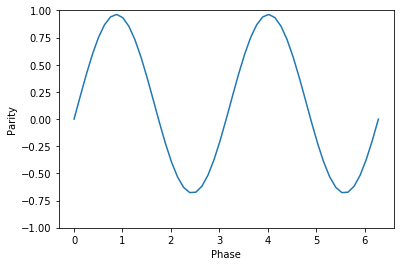

In [226]:
omega = 2e4
eta = 0.1
delta = 2*eta*omega
tg = 1/delta # pi/2 gate time
print('t_gate = '+str(tg*1e6)+'us')
nth = 0.1
Nmax = 10
exp2 = MSGateExp(Nmax=Nmax,eta = eta,
                 omega_r = np.array([omega,omega]) * np.pi * 2,
                 omega_b = np.array([omega,omega]) * np.pi * 2,
                 delta_r = np.array([delta,delta]) * np.pi * 2,
                 delta_b = np.array([-delta,-delta]) * np.pi * 2,
                 phi_r = 0,
                 phi_b = 0,
                 Gamma = 0, # Heating rate
                 nth = nth,
                 s_init = tensor(ket2dm(tensor(fock(2, 1), fock(2, 1))), thermal_dm(Nmax, nth)),
                 output = None)
t_Raman = 6e-6 # pi time
omega = np.pi/2/t_Raman
omega1 = omega
omega2 = omega
szz = exp2.parity_scan(t_gate = tg*1.2,
                    phi_list = np.linspace(0,2*np.pi, 51),
                    omega1 = omega1,
                    omega2 = omega2,
                    t_rotation = t_Raman/2 # pi/2 rotation
                         )

## Reasons of offset:
    3. Heating rate

t_gate = 250.0us


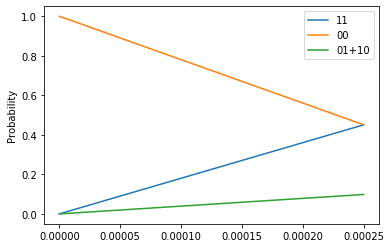

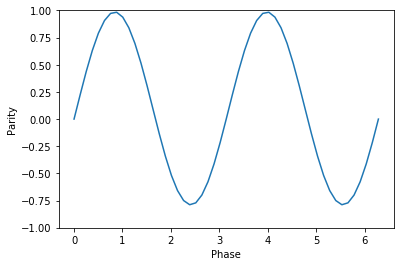

In [227]:
omega = 2e4
eta = 0.1
delta = 2*eta*omega
tg = 1/delta # pi/2 gate time
print('t_gate = '+str(tg*1e6)+'us')
nth = 0.1
Nmax = 10
exp2 = MSGateExp(Nmax=Nmax,eta = eta,
                 omega_r = np.array([omega,omega]) * np.pi * 2,
                 omega_b = np.array([omega,omega]) * np.pi * 2,
                 delta_r = np.array([delta,delta]) * np.pi * 2,
                 delta_b = np.array([-delta,-delta]) * np.pi * 2,
                 phi_r = 0,
                 phi_b = 0,
                 Gamma = 1e3, # Heating rate
                 nth = nth,
                 s_init = tensor(ket2dm(tensor(fock(2, 1), fock(2, 1))), thermal_dm(Nmax, nth)),
                 output = None)
t_Raman = 6e-6 # pi time
omega = np.pi/2/t_Raman
omega1 = omega
omega2 = omega
szz = exp2.parity_scan(t_gate = tg,
                    phi_list = np.linspace(0,2*np.pi, 51),
                    omega1 = omega1,
                    omega2 = omega2,
                    t_rotation = t_Raman/2 # pi/2 rotation
                         )

In [228]:
szz.ptrace([0,1])

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.45069291-7.50392893e-18j 0.        +0.00000000e+00j
  0.        +0.00000000e+00j 0.04917387-4.41226557e-01j]
 [0.        +0.00000000e+00j 0.04917387+3.43196938e-17j
  0.04917387+3.53690805e-17j 0.        +0.00000000e+00j]
 [0.        +0.00000000e+00j 0.04917387-1.40426586e-17j
  0.04917387-1.28325173e-17j 0.        +0.00000000e+00j]
 [0.04917387+4.41226557e-01j 0.        +0.00000000e+00j
  0.        +0.00000000e+00j 0.45095934-1.46681926e-17j]]

## Reasons of small symmetric contrast:
    1. two carrier unbalance

t_gate = 250.0us


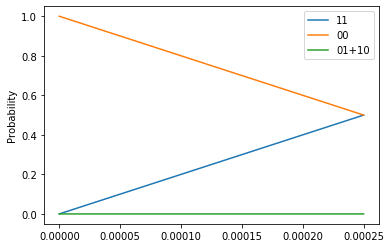

0:00:00.168122


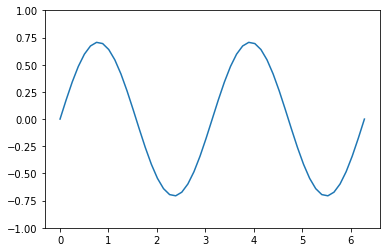

In [132]:
omega = 2e4
eta = 0.1
delta = 2*eta*omega
tg = 1/delta # pi/2 gate time
print('t_gate = '+str(tg*1e6)+'us')
nth = 0.1
Nmax = 10
exp2 = MSGateExp(Nmax=Nmax,eta = eta,
                 omega_r = np.array([omega,omega]) * np.pi * 2,
                 omega_b = np.array([omega,omega]) * np.pi * 2,
                 delta_r = np.array([delta,delta]) * np.pi * 2,
                 delta_b = np.array([-delta,-delta]) * np.pi * 2,
                 phi_r = 0,
                 phi_b = 0,
                 Gamma = 0, # Heating rate
                 nth = nth,
                 s_init = tensor(ket2dm(tensor(fock(2, 1), fock(2, 1))), thermal_dm(Nmax, nth)),
                 output = None)
t_Raman = 6e-6 # pi time
omega = np.pi/2/t_Raman
omega1 = omega
omega2 = omega
szz = exp2.parity_scan(t_gate = tg,
                    phi_list = np.linspace(0,2*np.pi, 51),
                    omega1 = omega1,
                    omega2 = omega2*0.5,
                    t_rotation = t_Raman/2 # pi/2 rotation
                         )

## Small contrast
    motional decoherence

t_gate = 500.0us


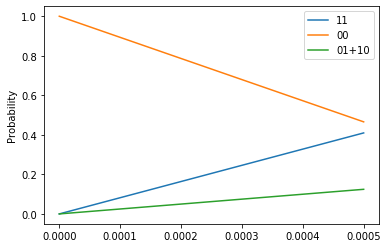

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.40973801-2.55768274e-17j 0.        +0.00000000e+00j
  0.        +0.00000000e+00j 0.06224052-3.61193844e-01j]
 [0.        +0.00000000e+00j 0.06224052+1.70023448e-17j
  0.06224052+1.37609414e-17j 0.        +0.00000000e+00j]
 [0.        +0.00000000e+00j 0.06224052+1.72032638e-17j
  0.06224052+1.16771212e-17j 0.        +0.00000000e+00j]
 [0.06224052+3.61193844e-01j 0.        +0.00000000e+00j
  0.        +0.00000000e+00j 0.46578094-2.93957944e-18j]]

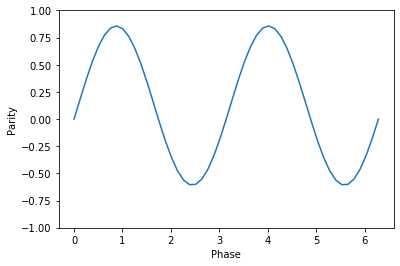

In [211]:
omega = 1e4
eta = 0.1
delta = 2*eta*omega
tg = 1/delta # pi/2 gate time
print('t_gate = '+str(tg*1e6)+'us')
nth = 0.1
Nmax = 10
exp2 = MSGateExp(Nmax=Nmax,eta = eta,
                 omega_r = np.array([omega,omega]) * np.pi * 2,
                 omega_b = np.array([omega,omega]) * np.pi * 2,
                 delta_r = np.array([delta,delta]) * np.pi * 2,
                 delta_b = np.array([-delta,-delta]) * np.pi * 2,
                 phi_r = 0,
                 phi_b = 0,
                 Gamma = 0, # Heating rate
                 tau = 1e-3, # Motional decoherence time in second
                 nth = nth,
                 s_init = tensor(ket2dm(tensor(fock(2, 1), fock(2, 1))), thermal_dm(Nmax, nth)),
                 output = None)
t_Raman = 6e-6 # pi time
omega = np.pi/2/t_Raman
omega1 = omega
omega2 = omega
szz = exp2.parity_scan(t_gate = tg,
                    phi_list = np.linspace(0,2*np.pi, 51),
                    omega1 = omega1,
                    omega2 = omega2,
                    t_rotation = t_Raman/2 # pi/2 rotation
                         )
szz.ptrace([0,1])

t_gate = 500.0us


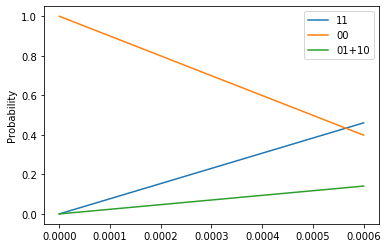

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.46070005+1.79461766e-17j 0.        +0.00000000e+00j
  0.        +0.00000000e+00j 0.07042913-4.05112363e-01j]
 [0.        +0.00000000e+00j 0.07042913-2.52087396e-17j
  0.07042913+2.47920070e-17j 0.        +0.00000000e+00j]
 [0.        +0.00000000e+00j 0.07042913-5.71982161e-17j
  0.07042913-1.44698965e-17j 0.        +0.00000000e+00j]
 [0.07042913+4.05112363e-01j 0.        +0.00000000e+00j
  0.        +0.00000000e+00j 0.39844169+1.81631628e-17j]]

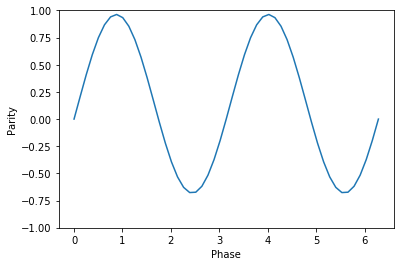

In [213]:
omega = 1e4
eta = 0.1
delta = 2*eta*omega
tg = 1/delta # pi/2 gate time
print('t_gate = '+str(tg*1e6)+'us')
nth = 0.1
Nmax = 10
exp2 = MSGateExp(Nmax=Nmax,eta = eta,
                 omega_r = np.array([omega,omega]) * np.pi * 2,
                 omega_b = np.array([omega,omega]) * np.pi * 2,
                 delta_r = np.array([delta,delta]) * np.pi * 2,
                 delta_b = np.array([-delta,-delta]) * np.pi * 2,
                 phi_r = 0,
                 phi_b = 0,
                 Gamma = 0, # Heating rate
                 tau = 1, # Motional decoherence time in second
                 nth = nth,
                 s_init = tensor(ket2dm(tensor(fock(2, 1), fock(2, 1))), thermal_dm(Nmax, nth)),
                 output = None)
t_Raman = 6e-6 # pi time
omega = np.pi/2/t_Raman
omega1 = omega
omega2 = omega
szz = exp2.parity_scan(t_gate = tg*1.2,
                    phi_list = np.linspace(0,2*np.pi, 51),
                    omega1 = omega1,
                    omega2 = omega2,
                    t_rotation = t_Raman/2 # pi/2 rotation
                         )
szz.ptrace([0,1])

#### No MS gate

t_gate = 250.0us


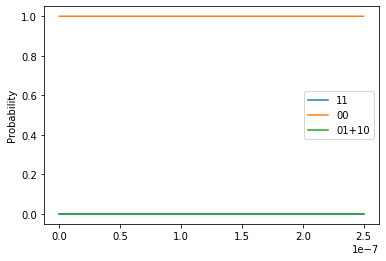

0:00:00.158161


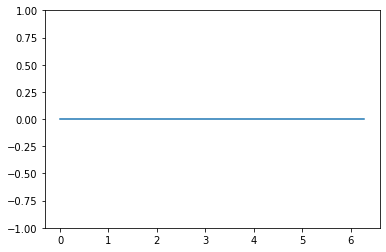

In [128]:
omega = 2e4
eta = 0.1
delta = 2*eta*omega
tg = 1/delta # pi/2 gate time
print('t_gate = '+str(tg*1e6)+'us')
nth = 0.1
Nmax = 10
exp2 = MSGateExp(Nmax=Nmax,eta = eta,
                 omega_r = np.array([omega,omega]) * np.pi * 2,
                 omega_b = np.array([omega,omega]) * np.pi * 2,
                 delta_r = np.array([delta,delta]) * np.pi * 2,
                 delta_b = np.array([-delta,-delta]) * np.pi * 2,
                 phi_r = 0,
                 phi_b = 0,
                 Gamma = 0, # Heating rate
                 nth = nth,
                 s_init = tensor(ket2dm(tensor(fock(2, 1), fock(2, 1))), thermal_dm(Nmax, nth)),
                 output = None)
t_Raman = 6e-6 # pi time
omega = np.pi/2/t_Raman
omega1 = omega
omega2 = omega
szz = exp2.parity_scan(t_gate = tg*0.001,
                    phi_list = np.linspace(0,2*np.pi, 51),
                    omega1 = omega1,
                    omega2 = omega2*1.7,
                    t_rotation = t_Raman/2 # pi/2 rotation
                         )

## Reasons of Phase shift

t_gate = 250.0us


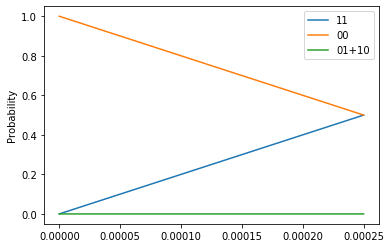

0:00:00.192780


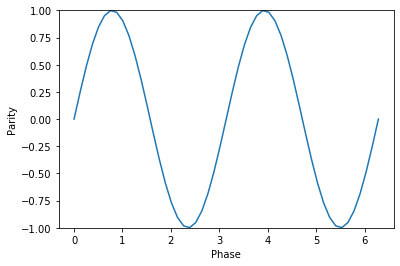

In [144]:
omega = 2e4
eta = 0.1
delta = 2*eta*omega
tg = 1/delta # pi/2 gate time
print('t_gate = '+str(tg*1e6)+'us')
nth = 0.1
Nmax = 10
exp2 = MSGateExp(Nmax=Nmax,eta = eta,
                 omega_r = np.array([omega,omega]) * np.pi * 2,
                 omega_b = np.array([omega,omega]) * np.pi * 2,
                 delta_r = np.array([delta,delta]) * np.pi * 2,
                 delta_b = np.array([-delta,-delta]) * np.pi * 2,
                 phi_r = 0,
                 phi_b = 0,
                 Gamma = 0, # Heating rate
                 nth = nth,
                 s_init = tensor(ket2dm(tensor(fock(2, 1), fock(2, 1))), thermal_dm(Nmax, nth)),
                 output = None)
t_Raman = 6e-6 # pi time
omega = np.pi/2/t_Raman
omega1 = omega
omega2 = omega
szz = exp2.parity_scan(t_gate = tg,
                    phi_list = np.linspace(0,2*np.pi, 51),
                    omega1 = omega1,
                    omega2 = omega2,
                    t_rotation = t_Raman/2, # pi/2 rotation
                    deltaPhi = 0
                         )

1. Two single qubit rotations have phase difference

t_gate = 250.0us


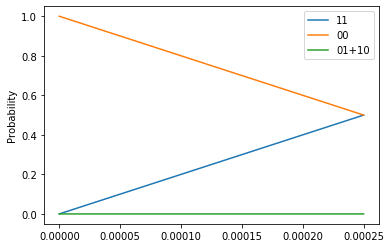

0:00:00.183861


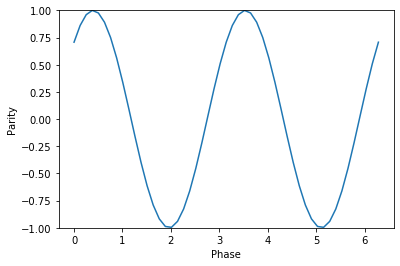

In [140]:
omega = 2e4
eta = 0.1
delta = 2*eta*omega
tg = 1/delta # pi/2 gate time
print('t_gate = '+str(tg*1e6)+'us')
nth = 0.1
Nmax = 10
exp2 = MSGateExp(Nmax=Nmax,eta = eta,
                 omega_r = np.array([omega,omega]) * np.pi * 2,
                 omega_b = np.array([omega,omega]) * np.pi * 2,
                 delta_r = np.array([delta,delta]) * np.pi * 2,
                 delta_b = np.array([-delta,-delta]) * np.pi * 2,
                 phi_r = 0,
                 phi_b = 0,
                 Gamma = 0, # Heating rate
                 nth = nth,
                 s_init = tensor(ket2dm(tensor(fock(2, 1), fock(2, 1))), thermal_dm(Nmax, nth)),
                 output = None)
t_Raman = 6e-6 # pi time
omega = np.pi/2/t_Raman
omega1 = omega
omega2 = omega
szz = exp2.parity_scan(t_gate = tg,
                    phi_list = np.linspace(0,2*np.pi, 51),
                    omega1 = omega1,
                    omega2 = omega2,
                    t_rotation = t_Raman/2, # pi/2 rotation
                    deltaPhi = np.pi/4
                         )

2. blue and red tones have phase difference 

t_gate = 250.0us


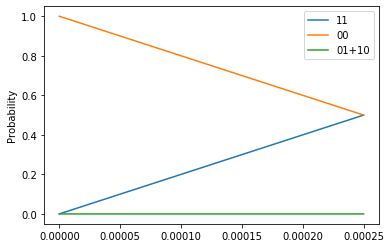

0:00:00.189393


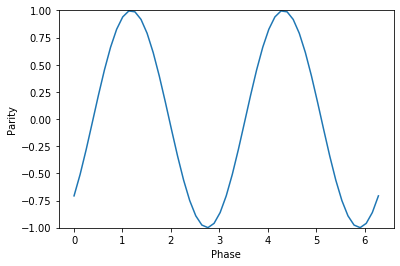

In [164]:
omega = 2e4
eta = 0.1
delta = 2*eta*omega
tg = 1/delta # pi/2 gate time
print('t_gate = '+str(tg*1e6)+'us')
nth = 0.1
Nmax = 10
exp2 = MSGateExp(Nmax=Nmax,eta = eta,
                 omega_r = np.array([omega,omega]) * np.pi * 2,
                 omega_b = np.array([omega,omega]) * np.pi * 2,
                 delta_r = np.array([delta,delta]) * np.pi * 2,
                 delta_b = np.array([-delta,-delta]) * np.pi * 2,
                 phi_r = 0,
                 phi_b = np.pi/4,
                 Gamma = 0, # Heating rate
                 nth = nth,
                 s_init = tensor(ket2dm(tensor(fock(2, 1), fock(2, 1))), thermal_dm(Nmax, nth)),
                 output = None)
t_Raman = 6e-6 # pi time
omega = np.pi/2/t_Raman
omega1 = omega
omega2 = omega
szz = exp2.parity_scan(t_gate = tg,
                    phi_list = np.linspace(0,2*np.pi, 51),
                    omega1 = omega1,
                    omega2 = omega2,
                    t_rotation = t_Raman/2, # pi/2 rotation
                    deltaPhi = 0
                         )

# Randomize the initial phase difference of blue and red tones
Ideal case, phase are kepted to be zero.

  0%|          | 0/51 [00:00<?, ?it/s]

t_gate = 250.0us


100%|██████████| 51/51 [00:33<00:00,  1.52it/s]


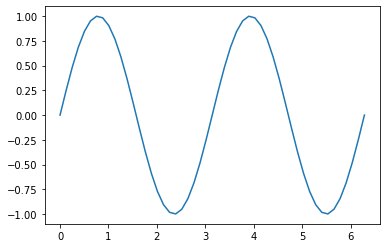

In [191]:
omega = 2e4
eta = 0.1
delta = 2*eta*omega
tg = 1/delta # pi/2 gate time
print('t_gate = '+str(tg*1e6)+'us')
nth = 0.1
Nmax = 10

t_Raman = 6e-6 # pi time
Omega = np.pi/2/t_Raman
omega1 = Omega
omega2 = Omega

phi_list = np.linspace(0,2*np.pi, 51)
szz = []
expr_num = 10
phi_b_list = [0]*expr_num
phi_r_list = [0]*expr_num
for phi in tqdm(phi_list):
    exp_result = 0
    for i in range(expr_num):      
        exp = MSGateExp(Nmax=Nmax,eta = eta,
                 omega_r = np.array([omega,omega]) * np.pi * 2,
                 omega_b = np.array([omega,omega]) * np.pi * 2,
                 delta_r = np.array([delta,delta]) * np.pi * 2,
                 delta_b = np.array([-delta,-delta]) * np.pi * 2,
                 phi_r = phi_r_list[i],
                 phi_b = phi_b_list[i],
                 Gamma = 0, # Heating rate
                 nth = nth,
                 s_init = tensor(ket2dm(tensor(fock(2, 1), fock(2, 1))), thermal_dm(Nmax, nth)),
                 output = None)

        exp_result+=exp.parity_scan_repeatable(
                    t_gate = tg,
                    phi = phi,
                    omega1 = omega1,
                    omega2 = omega2,
                    t_rotation = t_Raman/2, # pi/2 rotation
                    deltaPhi = 0
                 )
    szz.append(exp_result/expr_num)
    
plt.plot(phi_list, szz)
plt.xlabel('Phase')
plt.ylabel('Parity')
plt.ylim([-1.001,1.001])

Gaussian noise:
    
$\mu = 0, \quad \sigma = 0.1\times2\pi$ 

phi_b_list = `np.random.normal`($\mu, \sigma$, expr_num)

phi_r_list = `np.random.normal`($\mu, \sigma$, expr_num)

  0%|          | 0/51 [00:00<?, ?it/s]

t_gate = 250.0us


100%|██████████| 51/51 [00:30<00:00,  1.65it/s]


(-1.001, 1.001)

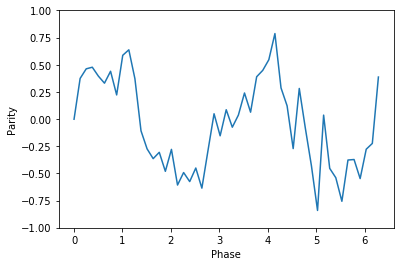

In [204]:
omega = 2e4
eta = 0.1
delta = 2*eta*omega
tg = 1/delta # pi/2 gate time
print('t_gate = '+str(tg*1e6)+'us')
nth = 0.1
Nmax = 10

t_Raman = 6e-6 # pi time
Omega = np.pi/2/t_Raman
omega1 = Omega
omega2 = Omega

phi_list = np.linspace(0,2*np.pi, 51)
szz = []
expr_num = 10
mu, sigma = 0, 0.1*2*np.pi # mean and standard deviation

for phi in tqdm(phi_list):
    exp_result = 0
    phi_b_list = np.random.normal(mu, sigma, expr_num)
    phi_r_list = phi_b_list
    for i in range(expr_num):      
        exp = MSGateExp(Nmax=Nmax,eta = eta,
                 omega_r = np.array([omega,omega]) * np.pi * 2,
                 omega_b = np.array([omega,omega]) * np.pi * 2,
                 delta_r = np.array([delta,delta]) * np.pi * 2,
                 delta_b = np.array([-delta,-delta]) * np.pi * 2,
                 phi_r = phi_r_list[i],
                 phi_b = phi_b_list[i],
                 Gamma = 0, # Heating rate
                 nth = nth,
                 s_init = tensor(ket2dm(tensor(fock(2, 1), fock(2, 1))), thermal_dm(Nmax, nth)),
                 output = None)

        exp_result+=exp.parity_scan_repeatable(
                    t_gate = tg,
                    phi = phi,
                    omega1 = omega1,
                    omega2 = omega2,
                    t_rotation = t_Raman/2, # pi/2 rotation
                    deltaPhi = 0
                 )
    szz.append(exp_result/expr_num)
    
plt.plot(phi_list, szz)
plt.xlabel('Phase')
plt.ylabel('Parity')
plt.ylim([-1.001,1.001])

White noise: 

    phi_b_list = [rd.random()*2*np.pi for i in range(expr_num)]

    phi_r_list = [rd.random()*2*np.pi for i in range(expr_num)]

  0%|          | 0/51 [00:00<?, ?it/s]

t_gate = 250.0us


100%|██████████| 51/51 [05:24<00:00,  6.36s/it]


(-1.001, 1.001)

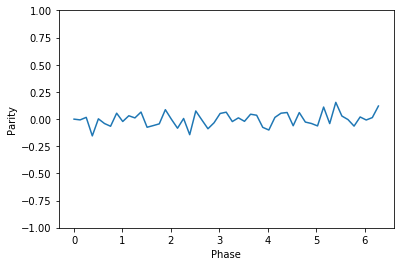

In [203]:
import random as rd
omega = 2e4
eta = 0.1
delta = 2*eta*omega
tg = 1/delta # pi/2 gate time
print('t_gate = '+str(tg*1e6)+'us')
nth = 0.1
Nmax = 10

t_Raman = 6e-6 # pi time
Omega = np.pi/2/t_Raman
omega1 = Omega
omega2 = Omega

phi_list = np.linspace(0,2*np.pi, 51)
szz = []
expr_num = 100

for phi in tqdm(phi_list):
    exp_result = 0
    phi_b_list = [rd.random()*2*np.pi for i in range(expr_num)]
    phi_r_list = [rd.random()*2*np.pi for i in range(expr_num)]
    for i in range(expr_num):      
        exp = MSGateExp(Nmax=Nmax,eta = eta,
                 omega_r = np.array([omega,omega]) * np.pi * 2,
                 omega_b = np.array([omega,omega]) * np.pi * 2,
                 delta_r = np.array([delta,delta]) * np.pi * 2,
                 delta_b = np.array([-delta,-delta]) * np.pi * 2,
                 phi_r = phi_r_list[i],
                 phi_b = phi_b_list[i],
                 Gamma = 0, # Heating rate
                 nth = nth,
                 s_init = tensor(ket2dm(tensor(fock(2, 1), fock(2, 1))), thermal_dm(Nmax, nth)),
                 output = None)

        exp_result+=exp.parity_scan_repeatable(
                    t_gate = tg,
                    phi = phi,
                    omega1 = omega1,
                    omega2 = omega2,
                    t_rotation = t_Raman/2, # pi/2 rotation
                    deltaPhi = 0
                 )
    szz.append(exp_result/expr_num)
    
plt.plot(phi_list, szz)
plt.xlabel('Phase')
plt.ylabel('Parity')
plt.ylim([-1.001,1.001])

## Amplitude fluctuation
This contrast will add the intercept of the parity scan vs. gate number fit. But will not affect the slope. 

  0%|          | 0/51 [00:00<?, ?it/s]

t_gate = 250.0us


100%|██████████| 51/51 [05:14<00:00,  6.17s/it]


(-1.001, 1.001)

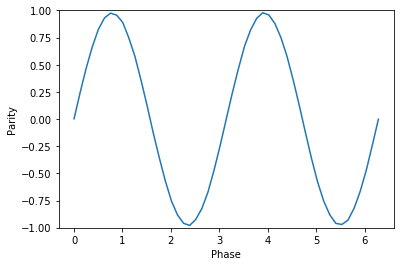

In [236]:
omega = 2e4
eta = 0.1
delta = 2*eta*omega
tg = 1/delta # pi/2 gate time
print('t_gate = '+str(tg*1e6)+'us')
nth = 0.1
Nmax = 10

t_Raman = 6e-6 # pi time
Omega = np.pi/2/t_Raman

phi_list = np.linspace(0,2*np.pi, 51)
szz = []
expr_num = 100
mu, sigma = Omega, 0.1*Omega # mean and standard deviation

for phi in tqdm(phi_list):
    exp_result = 0
    omega1_list = np.random.normal(mu, sigma, expr_num)
    omega2_list = np.random.normal(mu, sigma, expr_num)
    for i in range(expr_num):      
        exp = MSGateExp(Nmax=Nmax,eta = eta,
                 omega_r = np.array([omega,omega]) * np.pi * 2,
                 omega_b = np.array([omega,omega]) * np.pi * 2,
                 delta_r = np.array([delta,delta]) * np.pi * 2,
                 delta_b = np.array([-delta,-delta]) * np.pi * 2,
                 phi_r = 0,
                 phi_b = 0,
                 Gamma = 0, # Heating rate
                 nth = nth,
                 s_init = tensor(ket2dm(tensor(fock(2, 1), fock(2, 1))), thermal_dm(Nmax, nth)),
                 output = None)

        exp_result+=exp.parity_scan_repeatable(
                    t_gate = tg,
                    phi = phi,
                    omega1 = omega1_list[i],
                    omega2 = omega2_list[i],
                    t_rotation = t_Raman/2, # pi/2 rotation
                    deltaPhi = 0
                 )
        #print('omega1 = '+str(omega1_list[i])+', omega2 = '+str(omega2_list[i]))
    szz.append(exp_result/expr_num)
    
plt.plot(phi_list, szz)
plt.xlabel('Phase')
plt.ylabel('Parity')
plt.ylim([-1.001,1.001])
print('Contrast = ', (max(szz)-min(szz))/2)

In [239]:
print('Contrast = ', (max(szz)-min(szz))/2)

Contrast =  0.9789123244721183


  0%|          | 0/51 [00:00<?, ?it/s]

t_gate = 250.0us


100%|██████████| 51/51 [05:17<00:00,  6.22s/it]

Contrast =  0.992298672622666


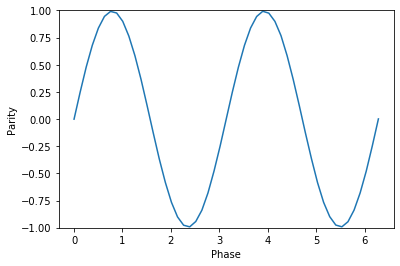

In [240]:
omega = 2e4
eta = 0.1
delta = 2*eta*omega
tg = 1/delta # pi/2 gate time
print('t_gate = '+str(tg*1e6)+'us')
nth = 0.1
Nmax = 10

t_Raman = 6e-6 # pi time
Omega = np.pi/2/t_Raman

phi_list = np.linspace(0,2*np.pi, 51)
szz = []
expr_num = 100
mu, sigma = Omega, 0.05*Omega # mean and standard deviation

for phi in tqdm(phi_list):
    exp_result = 0
    omega1_list = np.random.normal(mu, sigma, expr_num)
    omega2_list = np.random.normal(mu, sigma, expr_num)
    for i in range(expr_num):      
        exp = MSGateExp(Nmax=Nmax,eta = eta,
                 omega_r = np.array([omega,omega]) * np.pi * 2,
                 omega_b = np.array([omega,omega]) * np.pi * 2,
                 delta_r = np.array([delta,delta]) * np.pi * 2,
                 delta_b = np.array([-delta,-delta]) * np.pi * 2,
                 phi_r = 0,
                 phi_b = 0,
                 Gamma = 0, # Heating rate
                 nth = nth,
                 s_init = tensor(ket2dm(tensor(fock(2, 1), fock(2, 1))), thermal_dm(Nmax, nth)),
                 output = None)

        exp_result+=exp.parity_scan_repeatable(
                    t_gate = tg,
                    phi = phi,
                    omega1 = omega1_list[i],
                    omega2 = omega2_list[i],
                    t_rotation = t_Raman/2, # pi/2 rotation
                    deltaPhi = 0
                 )
        #print('omega1 = '+str(omega1_list[i])+', omega2 = '+str(omega2_list[i]))
    szz.append(exp_result/expr_num)
    
plt.plot(phi_list, szz)
plt.xlabel('Phase')
plt.ylabel('Parity')
plt.ylim([-1.001,1.001])
print('Contrast = ', (max(szz)-min(szz))/2)

  0%|          | 0/51 [00:00<?, ?it/s]

t_gate = 250.0us


100%|██████████| 51/51 [05:13<00:00,  6.14s/it]

Contrast =  0.9489299287593447


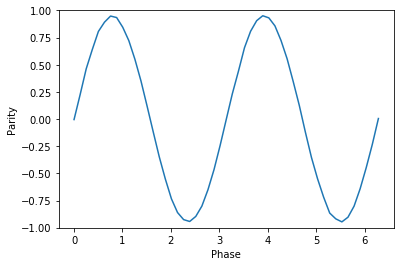

In [241]:
omega = 2e4
eta = 0.1
delta = 2*eta*omega
tg = 1/delta # pi/2 gate time
print('t_gate = '+str(tg*1e6)+'us')
nth = 0.1
Nmax = 10

t_Raman = 6e-6 # pi time
Omega = np.pi/2/t_Raman

phi_list = np.linspace(0,2*np.pi, 51)
szz = []
expr_num = 100
mu, sigma = Omega, 0.15*Omega # mean and standard deviation

for phi in tqdm(phi_list):
    exp_result = 0
    omega1_list = np.random.normal(mu, sigma, expr_num)
    omega2_list = np.random.normal(mu, sigma, expr_num)
    for i in range(expr_num):      
        exp = MSGateExp(Nmax=Nmax,eta = eta,
                 omega_r = np.array([omega,omega]) * np.pi * 2,
                 omega_b = np.array([omega,omega]) * np.pi * 2,
                 delta_r = np.array([delta,delta]) * np.pi * 2,
                 delta_b = np.array([-delta,-delta]) * np.pi * 2,
                 phi_r = 0,
                 phi_b = 0,
                 Gamma = 0, # Heating rate
                 nth = nth,
                 s_init = tensor(ket2dm(tensor(fock(2, 1), fock(2, 1))), thermal_dm(Nmax, nth)),
                 output = None)

        exp_result+=exp.parity_scan_repeatable(
                    t_gate = tg,
                    phi = phi,
                    omega1 = omega1_list[i],
                    omega2 = omega2_list[i],
                    t_rotation = t_Raman/2, # pi/2 rotation
                    deltaPhi = 0
                 )
        #print('omega1 = '+str(omega1_list[i])+', omega2 = '+str(omega2_list[i]))
    szz.append(exp_result/expr_num)
    
plt.plot(phi_list, szz)
plt.xlabel('Phase')
plt.ylabel('Parity')
plt.ylim([-1.001,1.001])
print('Contrast = ', (max(szz)-min(szz))/2)

### Check the raman rotation parameters

In [62]:
t_Raman = 6e-6
omega = np.pi/2/t_Raman
omega1 = omega
omega2 = omega
Nmax = 10
phi= 0.0

sigma_phi = np.cos(phi)*sigmax() - np.sin(phi)*sigmay()
H1 = omega1*tensor(sigma_phi, qeye(2), qeye(Nmax))
H2 = omega2*tensor(qeye(2), sigma_phi, qeye(Nmax))
H = H1+H2
tlist = np.linspace(0, t_Raman/2, 101)
s_init = tensor(ket2dm(tensor(fock(2, 1), fock(2, 1))), thermal_dm(Nmax, 0.1))
output = mesolve(H, s_init, tlist, [], [])

szs = [(state.ptrace([0,1])*tensor(sigmaz(),qeye(2))).tr() for state in output.states]
szzs = [(state.ptrace([0,1])*tensor(sigmaz(),sigmaz())).tr() for state in output.states]

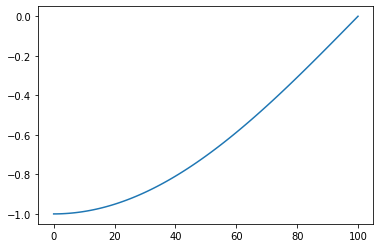

In [63]:
plt.plot(szs)

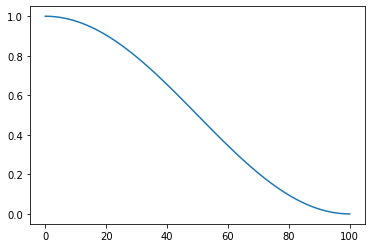

In [64]:
plt.plot(szzs)

In [216]:
tensor(sigmay(),sigmax()) - tensor(sigmax(), sigmay())

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.-2.j 0.+0.j]
 [0.+0.j 0.+2.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]